In [96]:
from __future__ import print_function
from pymongo import MongoClient
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import re
import string
import sys
import os

import jellyfish # library for fuzzy text comparisons
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

from tqdm import tqdm_pandas, tqdm_notebook as tqdm
from tqdm import tqdm as tqorig
tqorig.pandas(tqdm)
from autocorrect import spell
from textblob import TextBlob

[nltk_data] Downloading package wordnet to /Users/natali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [97]:
client = MongoClient()
db     = client.fletcher
reviews   = db.reviews

In [98]:
cursor = reviews.find({},{ 'text_review OVERALL UNIVERSITY RATING': 1, 'college' : 1})

In [99]:
df_overall_review = pd.DataFrame(list(cursor))

In [100]:
alphanumeric = lambda x: re.sub('\w*\d\w*', ' ', x)
punc_lower = lambda x: re.sub('[%s]' % re.escape(string.punctuation), ' ', x.lower())
letters_only = lambda x: re.sub("[^a-zA-Z]", " ", str(x))


df_overall_review['reviews'] = df_overall_review['text_review OVERALL UNIVERSITY RATING'].map(letters_only).map(alphanumeric).map(punc_lower)
df_overall_review.head()

,_id,college,text_review OVERALL UNIVERSITY RATING,reviews
0,5c75db20c0bfe17384b4d259,"Northumbria University, Newcastle",great and helpful experience\nprovide good tea...,great and helpful experience provide good teac...
1,5c75db20c0bfe17384b4d262,University of Cumbria,enjoying it. good mix of lectures and practica...,enjoying it good mix of lectures and practica...
2,5c75db20c0bfe17384b4d26b,"Northumbria University, Newcastle","Sports centre is really a amazing place, Infra...",sports centre is really a amazing place infra...
3,5c75db20c0bfe17384b4d274,University of Hull,university has been interesting the first year...,university has been interesting the first year...
4,5c75db20c0bfe17384b4d27d,"Northumbria University, Newcastle","I am quite enjoy my university life at here, t...",i am quite enjoy my university life at here t...


In [101]:
df_overall_review['polarity'] = df_overall_review['reviews'].apply(lambda x: TextBlob(x).sentiment.polarity)

In [102]:
text = list(df_overall_review[df_overall_review['college'] == 'University of Cumbria']['reviews'])

In [103]:
tweets = [item for item in text]

In [19]:
tweets[9]

'despite being situated at a really small university it is really cosy and our own little community  your lecturers would know you personally which is a nice feeling  it is very inclusive and easy to get around  really love it here '

In [26]:
import nltk
from   nltk.stem.snowball import SnowballStemmer
from   more_itertools import unique_everseen

stopwords = nltk.corpus.stopwords.words('english')
stopwords.append(u'\u0027s')
stopwords.append(u'n\u0027t')
stopwords.append(u'\u0027m')
stopwords.append("'re")
stopwords.append("'ve")
print('Stop words (%i): \n%s\n' %(len(stopwords),[str(word) for word in stopwords]))

Stop words (184): 
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'sam

In [27]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens


In [29]:
stemmer = SnowballStemmer("english")
stemmed_stopwords = list(unique_everseen([stemmer.stem(word) for word in stopwords]))
print('Stemmed stop words (%i): \n%s\n' %(len(stemmed_stopwords),[str(word) for word in stemmed_stopwords]))

Stemmed stop words (172): 
['i', 'me', 'my', 'myself', 'we', 'our', 'ourselv', 'you', "you'r", "you'v", "you'll", "you'd", 'your', 'yourself', 'yourselv', 'he', 'him', 'his', 'himself', 'she', 'her', 'herself', 'it', 'itself', 'they', 'them', 'their', 'themselv', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'have', 'has', 'had', 'do', 'doe', 'did', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'becaus', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'dure', 'befor', 'after', 'abov', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'onc', 'here', 'there', 'when', 'where', 'whi', 'how', 'all', 'ani', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'onli', 'own', 'same', 'so', 'than', 'too', 'veri', 's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "s

In [32]:
tokenized_tweets = [tokenize_only(tweet) for tweet in tweets]
stemmed_tweets   = [[stemmer.stem(word) for word in tweet] for tweet in tokenized_tweets]
filtered_tweets  = [[word for word in tweet if word not in stemmed_stopwords] for tweet in stemmed_tweets]

In [34]:
print('Example tweet after tokenization, stemming, and filtering:')
ind = 0
print(tokenized_tweets[ind])
print(stemmed_tweets[ind])
print(filtered_tweets[ind])
print(' ')

# Create a vocabulary to convert stems back to words:
vocab = {}
assert len(tokenized_tweets) == len(stemmed_tweets), 'Tokenized tweets: %i, Stemmed tweets: %i'\
                                                     %(len(tokenized_tweets),len(stemmed_tweets))
for tokenized_tweet,stemmed_tweet in zip(tokenized_tweets,stemmed_tweets):
    assert len(tokenized_tweet) == len(stemmed_tweet), \
            'Tweet length error:\n   tokenized tweet: "%s"\n   stemmed tweet: "%s"' %(tokenized_tweet,stemmed_tweet)
    for word,stem in zip(tokenized_tweet,stemmed_tweet):
        if stem not in stemmed_stopwords:
            vocab.setdefault(stem,word)
        
print('Length of vocabulary = %i' %len(vocab))
#print('Vocabulary Extract:\n %s' %([': '.join((str(key),value)) for (key,value) in vocab.items()[-50:]]))

Example tweet after tokenization, stemming, and filtering:
['enjoying', 'it', 'good', 'mix', 'of', 'lectures', 'and', 'practical', 'sessions', 'and', 'placements', 'can', 'be', 'hard', 'balancing', 'all', 'the', 'assignments', 'as', 'this', 'uni', 'gives', 'you', 'more', 'than', 'others', 'personal', 'tutors', 'are', 'very', 'helpful']
['enjoy', 'it', 'good', 'mix', 'of', 'lectur', 'and', 'practic', 'session', 'and', 'placement', 'can', 'be', 'hard', 'balanc', 'all', 'the', 'assign', 'as', 'this', 'uni', 'give', 'you', 'more', 'than', 'other', 'person', 'tutor', 'are', 'veri', 'help']
['enjoy', 'good', 'mix', 'lectur', 'practic', 'session', 'placement', 'hard', 'balanc', 'assign', 'uni', 'give', 'person', 'tutor', 'help']
 
Length of vocabulary = 1994


In [37]:
'''
Apply tfidf transformation and compute cosine similarity matrix.
max_df = maximum fraction of documents containing the word, for the word to be included in tfidf matrix
min_df = minimum fraction ...
ngram_range: We'll look at unigrams, bigrams and trigrams.
'''
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity


tfidf_vectorizer = TfidfVectorizer( max_df=0.80, max_features=200000, min_df=0.01, stop_words=stemmed_stopwords,
                                    analyzer='word', use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))
%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets)
dist  = 1 - cosine_similarity(tfidf_matrix)  # Matrix with cosine similarities between all tf-idf vectors
terms = tfidf_vectorizer.get_feature_names()
idf   = tfidf_vectorizer.idf_

print('\nNumber of documents = %i, Number of TF-IDF features = %i' %(tfidf_matrix.shape[0],tfidf_matrix.shape[1]))
print('\nTF-IDF features, with scores:')
for ind,(name,score) in enumerate(zip(terms,idf)):
    if ind%4 != 3:
        print('{2:3d}. {0:17} {1:.2f} | '.format(str(name)+':',score,ind),end='')
    else:
        print('{2:3d}. {0:17} {1:.2f}'.format(str(name)+':',score,ind))

/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", 'could', 'might', 'must', 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


CPU times: user 652 ms, sys: 5.94 ms, total: 658 ms
Wall time: 664 ms

Number of documents = 970, Number of TF-IDF features = 392

TF-IDF features, with scores:
  0. abl:              4.55 |   1. absolut:          4.93 |   2. academ:           4.12 |   3. access:           4.83
  4. accommod:         4.79 |   5. activ:            4.93 |   6. actual:           5.39 |   7. allow:            4.79
  8. alreadi:          5.05 |   9. also:             3.66 |  10. although:         4.55 |  11. alway:            3.62
 12. amaz:             3.55 |  13. amblesid:         5.24 |  14. amount:           5.39 |  15. anyon:            4.70
 16. anyth:            5.31 |  17. approach:         4.93 |  18. area:             4.99 |  19. around:           4.35
 20. ask:              5.05 |  21. aspect:           4.88 |  22. assess:           5.48 |  23. assign:           4.58
 24. attend:           5.05 |  25. avail:            4.58 |  26. away:             4.55 |  27. away home:        5.39
 28. back:   

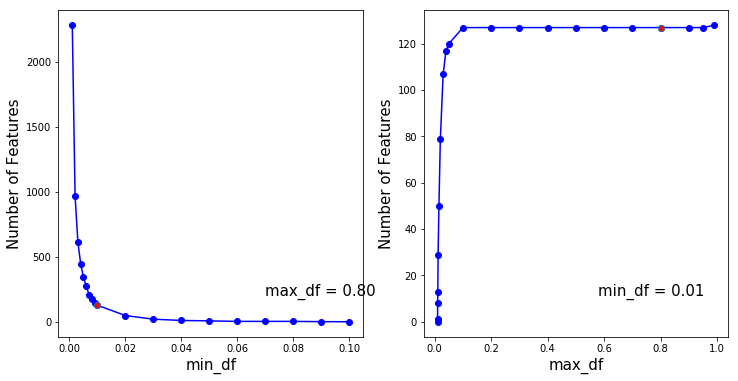

In [38]:
'''
Plot of the number of features as a function of min_df and max_df in the call to TfidfVectorizer
'''
fig, ax = plt.subplots( nrows=1, ncols=2, figsize=(12,6) )
mindf = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1]
nfeat = [2282,966,615,446,343,273,209,175,144,127,48,20,10,7,3,3,3,1,0]
ax[0].plot( mindf, nfeat, marker='o', markerfacecolor='b', linestyle='-', color='b', alpha=1.0 )
ax[0].plot( 0.01, 127, marker='o', markerfacecolor='r', alpha=1.0 )
ax[0].set_xlabel('min_df', fontsize=15)
ax[0].set_ylabel('Number of Features', fontsize=15)
ax[0].text(0.07,200.0,'max_df = 0.80',fontsize=15)
maxdf = [0.01,0.0102,0.0105,0.011,0.012,0.015,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
nfeat = [0,1,8,13,29,50,79,107,117,120,127,127,127,127,127,127,127,127,127,127,128]
ax[1].plot( maxdf, nfeat, marker='o', markerfacecolor='b', linestyle='-', color='b', alpha=1.0 )
ax[1].plot( 0.80, 127, marker='o', markerfacecolor='r', alpha=1.0 )
ax[1].set_xlabel('max_df', fontsize=15)
ax[1].set_ylabel('Number of Features', fontsize=15)
ax[1].text(0.58,11.2,'min_df = 0.01',fontsize=15)
plt.show()
fig.savefig('tfidf_features.png', dpi=200)

In [40]:
import nltk
from gensim import corpora

def ngrams(tokens, n):
    """Extend a list of tokens with its own space-separated i-grams, where i = 2,...,n."""
    tokens1 = tokens[:]
    if n > 1:
        tokens0 = tokens[:]
        for i in range(2,n+1):
            tokens1.extend([' '.join(a) for a in nltk.ngrams(tokens0,i)])
    return tokens1

# Extend tweets with n-grams.
extended_tweets  = [ngrams(tweet,3) for tweet in filtered_tweets]

# Build dictionary for gensim.
dictionary       = corpora.Dictionary(extended_tweets)
num_below        = int( 0.01 * len(extended_tweets) )
dictionary.filter_extremes(no_below=num_below, no_above=0.80, keep_n=None)
n_terms          = len(dictionary)
n_docs           = len(extended_tweets)

# Print some info.
print(dictionary)
print(' ')
ind = 0
for key,value in sorted(dictionary.token2id.items()):
    if ind%4 != 3:
        print('{0:17} {1:3d} | '.format(key+":",value),end='')
    else:
        print('{0:17} {1:3d}'.format(key+":",value))
    ind += 1

Dictionary(443 unique tokens: ['assign', 'enjoy', 'give', 'good', 'hard']...)
 
abl:              210 | absolut:          416 | academ:            15 | access:           186
accommod:         267 | achiev:           198 | activ:            138 | actual:           159
advic:            432 | allow:            268 | along:            199 | alreadi:          168
also:             117 | although:         118 | alway:             43 | amaz:              44
amblesid:         394 | amount:           187 | anyon:            282 | anyth:            314
approach:         194 | area:             244 | around:            92 | ask:              283
aspect:           280 | assess:           391 | assign:             0 | attend:           129
avail:             45 | away:             212 | away home:        369 | back:             321
bad:              195 | base:             418 | beauti:           400 | becom:            312
believ:           130 | best:              29 | better:            83 | bi

/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: generator 'ngrams' raised StopIteration
  # Remove the CWD from sys.path while we load stuff.


In [42]:
dictionary.token2id.items()

dict_items([('assign', 0), ('enjoy', 1), ('give', 2), ('good', 3), ('hard', 4), ('help', 5), ('lectur', 6), ('mix', 7), ('person', 8), ('placement', 9), ('practic', 10), ('session', 11), ('tutor', 12), ('tutor help', 13), ('uni', 14), ('academ', 15), ('differ', 16), ('due', 17), ('event', 18), ('like', 19), ('love', 20), ('night', 21), ('offer', 22), ('student', 23), ('support', 24), ('teach', 25), ('time', 26), ('time univers', 27), ('univers', 28), ('best', 29), ('career', 30), ('choic', 31), ('class', 32), ('cours', 33), ('done', 34), ('educ', 35), ('first', 36), ('recommend', 37), ('return', 38), ('right', 39), ('thing', 40), ('would', 41), ('would recommend', 42), ('alway', 43), ('amaz', 44), ('avail', 45), ('campus', 46), ('definit', 47), ('easi', 48), ('excel', 49), ('experi', 50), ('matur', 51), ('matur student', 52), ('recommend univers', 53), ('resourc', 54), ('someth', 55), ('use', 56), ('welcom', 57), ('chose', 58), ('citi', 59), ('enjoy cours', 60), ('go', 61), ('great', 6

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

no_features = 1000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(tweets)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tf = tf_vectorizer.fit_transform(tweets)
tf_feature_names = tf_vectorizer.get_feature_names()

In [77]:
from sklearn.decomposition import NMF, LatentDirichletAllocation
import lda
no_topics = 5

# Run NMF
nmf = NMF(n_components=no_topics, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)

# Run LDA
lda = LatentDirichletAllocation(n_topics=no_topics, max_iter=5, learning_method='online', learning_offset=50.,random_state=0).fit(tf)

/Users/natali/anaconda3/envs/py37/lib/python3.6/site-packages/sklearn/decomposition/online_lda.py:314: DeprecationWarning: n_topics has been renamed to n_components in version 0.19 and will be removed in 0.21
  DeprecationWarning)


In [73]:
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')

In [78]:
lda.components_

array([[ 0.31862089,  1.03410045,  1.11231634, ...,  0.31262461,
         0.28626526,  0.31959158],
       [ 0.29383576,  0.30651215,  0.45798448, ...,  0.28717979,
         0.31257038,  0.29134814],
       [ 0.30116616,  0.27432382,  0.29907705, ...,  1.08050835,
         0.30273873,  0.27729545],
       [ 3.4862341 ,  0.33458369, 25.96780229, ...,  2.00333828,
         5.91538063,  2.76929776],
       [ 0.29434428,  1.21223255,  0.31259871, ...,  0.28872615,
         0.4862656 ,  0.29997966]])

In [81]:
X_topics = lda.components_

In [82]:
tsne_lda = tsne_model.fit_transform(X_topics)

[t-SNE] Computing 4 nearest neighbors...
[t-SNE] Indexed 5 samples in 0.000s...
[t-SNE] Computed neighbors for 5 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 5 / 5
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 44.327560
[t-SNE] KL divergence after 1000 iterations: 0.101658


In [83]:
n_top_words = 5 # number of keywords we show

# 20 colors
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    
])

In [87]:
X_topics.shape[0]

5

In [93]:
_lda_keys = []
for i in range(X_topics.shape[0]):
    _lda_keys +=  lda.components_[i].argmax(),

In [91]:
topic

3

In [95]:
topic_summaries = []
topic_word = lda_model.topic_word_  # all topic words
vocab = cvectorizer.get_feature_names()
for i, topic_dist in enumerate(topic_word):
  topic_words = np.array(vocab)[np.argsort(topic_dist)][:-(n_top_words + 1):-1] # get!
  topic_summaries.append(' '.join(topic_words)) # append!

AttributeError: 'LatentDirichletAllocation' object has no attribute 'topic_word_'

In [89]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}".format(topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 5
display_topics(nmf, tfidf_feature_names, no_top_words)
display_topics(lda, tf_feature_names, no_top_words)

Topic 0
nan zone experiences far fantastic
Topic 1
university course experience uni feel
Topic 2
good far facilities experience uni
Topic 3
great far met fun uni
Topic 4
really enjoyed enjoying course ve
Topic 0
brill alright answer terms stress
Topic 1
societies good flat university extra
Topic 2
nan characters needed worst poorly
Topic 3
university good course experience uni
Topic 4
behaviour methods different plan talk
